In [1]:
import pandas as pd
from mainnet_launch.constants import (
    eth_client,
)
from mainnet_launch.destinations import get_destination_details
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.destination_diagnostics.fetch_destination_summary_stats import _build_summary_stats_call

import warnings

destination_details = get_destination_details()

2024-10-28 17:15:58.092 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 17:15:58.096 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 17:15:58.098 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 17:15:58.182 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 17:15:58.183 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 17:15:58.347 
  command:

    streamlit run /home/parker/Documents/Tokemak/v2-rebalance-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-28 17:15:58.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-2

In [12]:
[d for d in destination_details if "ETHx/wstETH" in d.vault_name]

[Destination Details:
  vaultAddress	: 0xfB6f99FdF12E37Bfe3c4Cf81067faB10c465fb24
  exchangeName	: balancer
  dexPool	: 0xB91159aa527D4769CB9FAf3e4ADB760c7E8C8Ea7
  lpTokenAddress	: 0xB91159aa527D4769CB9FAf3e4ADB760c7E8C8Ea7
  lpTokenSymbol	: ETHx/wstETH
  lpTokenName	: Balancer ETHx/wstETH
  autopool	: {'name': 'Tokemak autoETH', 'autopool_eth_addr': '0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56', 'autopool_eth_strategy_addr': '0xf5f6addB08c5e6091e5FdEc7326B21bEEd942235', 'solver_rebalance_plans_bucket': 'v2-gen3-eth-mainnet-solve-v2gen3ethmainnetsolverau-7ju0ra8aoznh'}
  vault_name	: ETHx/wstETH (balancer),
 Destination Details:
  vaultAddress	: 0xfB6f99FdF12E37Bfe3c4Cf81067faB10c465fb24
  exchangeName	: balancer
  dexPool	: 0xB91159aa527D4769CB9FAf3e4ADB760c7E8C8Ea7
  lpTokenAddress	: 0xB91159aa527D4769CB9FAf3e4ADB760c7E8C8Ea7
  lpTokenSymbol	: ETHx/wstETH
  lpTokenName	: Balancer ETHx/wstETH
  autopool	: {'name': 'Balancer/Tokemak balETH', 'autopool_eth_addr': '0x6dC3ce9C57b20131347F

In [ ]:
# https://balancer.fi/pools/ethereum/v2/0xb91159aa527d4769cb9faf3e4adb760c7e8c8ea700000000000000000000067c

In [9]:
from multicall import Call

from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
)

In [16]:
def build_wstETH_weth_pool_get_rate(name: str) -> Call:
    return Call(
        "0xB91159aa527D4769CB9FAf3e4ADB760c7E8C8Ea7",
        ["getRate()(uint256)"],
        [(name, safe_normalize_with_bool_success)],
    )


# this pool only has wstETH and ETHx in it, asssume that base apr is (2.5 - 3) (after taxes 1.75 - 1.5)

calls = [build_wstETH_weth_pool_get_rate("pool_vp")]
sep_15 = 20752910
oct_15 = 20971910
start = get_state_by_one_block(calls, sep_15)
end = get_state_by_one_block(calls, oct_15)
start_second = eth_client.eth.get_block(sep_15).timestamp
end_second = eth_client.eth.get_block(oct_15).timestamp
seconds_taken = end_second - start_second
portion_of_a_year = seconds_taken / (604800 * 52)
portion_of_a_year

0.08397016178266178

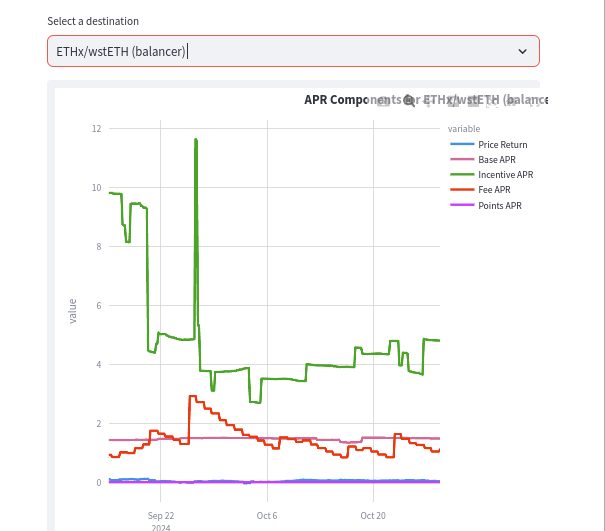

In [19]:
apr = (100 * (end["pool_vp"] - start["pool_vp"]) / start["pool_vp"]) / portion_of_a_year
# the pure rate of growth in virtual price is 2.9%
# this seems like it matches up with the fee + base, or close enoough
apr

2.935845682982876

In [20]:
# back of the napkin

pool_usd_tvl = 1_800_000  # estimate
pool_usd_fees = 2275
100 * pool_usd_fees * 12 / pool_usd_tvl

# this is tracking, the ETHx / wstETH pool has a 1 month estiamte fee apr of 1.5% and a 1 month total return of 2.9 % and expected base APR of 1.5%
# this is looking right https://balancer.fi/pools/ethereum/v2/0xb91159aa527d4769cb9faf3e4adb760c7e8c8ea700000000000000000000067c

1.5166666666666666